In [23]:
# Import required libraries
import cv2
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the YOLO object detection model
model = YOLO('runs/segment/train/weights/best.pt')

# Read the input image
img = cv2.imread("6.jpeg")

# Run object detection on the input image
res = model(img, conf=0.1)
res_plotted = res[0].plot()

# Get the segmentation mask from the YOLO output
mask = res[0].masks

# Create a black mask of the same size as the image
mask_seg = np.zeros_like(img)

# Loop through all contour points in the segmentation mask
for point in range(len(mask.xy)):
    contour_points = mask.xy[point]
    # Convert contour points to an array of shape (n, 1, 2)
    contour_points = contour_points.reshape((-1, 1, 2)).astype(np.int32)
    # Fill the contour with white color (255) on the mask
    cv2.fillPoly(mask_seg, [contour_points], color=(255, 255, 255))
    
# Apply the mask on the original image to extract the region of interest (teeth)
result = cv2.bitwise_and(img, mask_seg)

# Write the output image to disk
cv2.imwrite("FillMask.jpg", result)



0: 320x416 21 teeths, 147.8ms
Speed: 0.7ms preprocess, 147.8ms inference, 31.0ms postprocess per image at shape (1, 3, 416, 416)


True

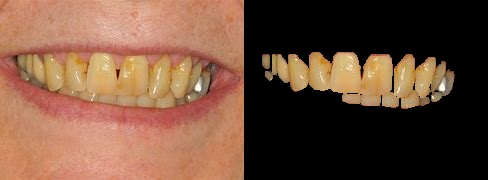

In [28]:
from PIL import Image

# Concatenate images horizontally
im_h = cv2.hconcat([img, result])
cv2.imwrite("img_result.jpg",im_h)
image = Image.open("img_result.jpg")
image.show()

# from matplotlib import pyplot as plt
# import cv2

# img = cv2.imread('FillMask.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plt.imshow(gray)
# plt.title('my picture')
# plt.show()

In [25]:

# Load the test image and print its type
test_image = cv2.imread('FillMask.jpg')
print(type(test_image))

# Calculate histogram for each color channel of the test image
hist_b = cv2.calcHist([test_image], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([test_image], [1], None, [256], [0, 256])
hist_r = cv2.calcHist([test_image], [2], None, [256], [0, 256])

# Remove first element from each histogram and normalize them
hist_b_0 = np.delete(hist_b, 0)
hist_g_0 =np.delete(hist_b, 0)
hist_r_0 = np.delete(hist_b, 0)

hist_b_0 = hist_b_0/np.sum(hist_b_0)
hist_g_0 =hist_g_0/np.sum(hist_g_0)
hist_r_0 = hist_r_0/np.sum(hist_r_0)

# Concatenate the normalized histograms to form a single row array
con_test = np.concatenate((hist_b_0, hist_g_0,hist_r_0))
con_test = con_test.reshape(1, -1)

# Define directory where reference images are stored and retrieve their names
ref_dir = 'shades/'
ref_images = os.listdir(ref_dir)
print(ref_images)

best_match = None
# Initialize min_distance to -1 since cosine similarity can return negative values
min_distance = -1

# Iterate over all reference images
for ref_image_name in ref_images:
    # Build the path to the current reference image
    ref_image_path = os.path.join(ref_dir, ref_image_name)
    
    # Load the reference image and calculate its color histograms for each channel
    ref_image = cv2.imread(ref_image_path)
    hist_b = cv2.calcHist([ref_image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([ref_image], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([ref_image], [2], None, [256], [0, 256])

    # Remove first element from each histogram and normalize them
    hist_b_0 = np.delete(hist_b, 0)
    hist_g_0 =np.delete(hist_b, 0)
    hist_r_0 = np.delete(hist_b, 0)

    hist_b_0 = hist_b_0/np.sum(hist_b_0)
    hist_g_0 =hist_g_0/np.sum(hist_g_0)
    hist_r_0 = hist_r_0/np.sum(hist_r_0)

    # Concatenate the normalized histograms to form a single row array
    con_ref = np.concatenate((hist_b_0, hist_g_0,hist_r_0))
    con_ref=con_ref.reshape(1, -1)
    
    # Calculate cosine similarity between the reference image and test image
    distance = cosine_similarity(con_ref,con_test)
    print(distance)
    
    # Update the minimum distance and best match if the current distance is smaller than the current minimum distance
    if distance > min_distance:
        min_distance = distance
        best_match = ref_image_path

# Display the best match and its distance from the test image
print(f'Best match: {best_match[-5]}',min_distance)


<class 'numpy.ndarray'>
['E.jpg', 'A.jpg', 'D.jpg', 'C.jpg', 'B.jpg']
[[   0.025414]]
[[  0.0020944]]
[[  0.0068694]]
[[  0.0030051]]
[[  0.0031695]]
Best match: E [[   0.025414]]


In [26]:
# Define a function to change the brightness of an image
def color_change(pix):
    # Add the specified amount of brightness to the image
    brightened_img = cv2.add(test_image, np.array([pix]))
    
    # Apply the brightening effect only to the teeth in the image
    brightened_img = cv2.bitwise_and(brightened_img, mask_seg)
    
    # Create a mask to exclude the teeth from the original mask
    result=cv2.bitwise_not(mask_seg, mask=None)
    
    # Apply the inverted mask to the original image to get non-teeth portion
    result = cv2.bitwise_and(result, img)
    
    # Combine the brightened teeth and non-teeth portions of the image
    result = cv2.bitwise_or(brightened_img, result)
    
    # Return the resulting image
    return result

# Call the color_change() function five times with different values of pix
brightened_img1=color_change(25.0)
brightened_img2=color_change(50.0)
brightened_img3=color_change(75.0)
brightened_img4=color_change(100.0)
brightened_img5=color_change(125.0)

# Concatenate the five images horizontally
im_h = cv2.hconcat([brightened_img1, brightened_img2,brightened_img3,brightened_img4,brightened_img5])

# Add labels to each image
cv2.putText(im_h,'Shade: E',(0,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(im_h,'Shade: D',(brightened_img1.shape[1],30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(im_h,'Shade: C',(brightened_img1.shape[1]*2,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(im_h,'Shade: B',(brightened_img1.shape[1]*3,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(im_h,'Shade: A',(brightened_img1.shape[1]*4,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

# Save the concatenated image as 'whitened_teeth.jpg'
cv2.imwrite('whitened_teeth.jpg', im_h)


True

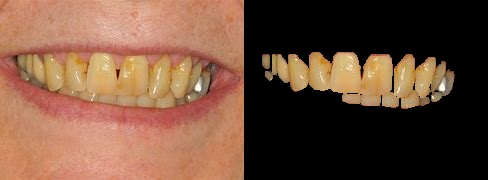

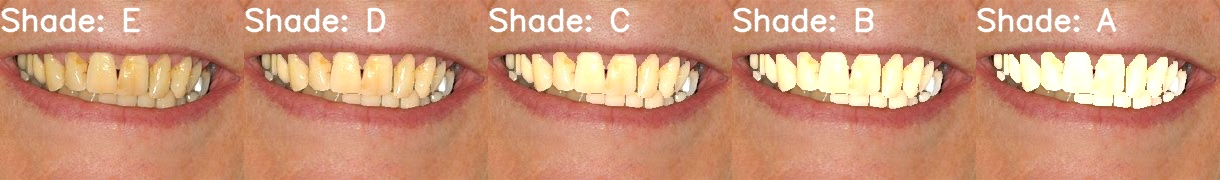

In [30]:
image = Image.open("img_result.jpg")
image.show()
image = Image.open('whitened_teeth.jpg')
image.show()